In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from google.colab import files
import io

In [ ]:
# uploaded = files.upload()

In [ ]:
df = pd.read_csv("search_11-11.csv")
second_df = pd.read_csv("search_11-04.csv")
third_df = pd.read_csv("search_10-28.csv")
concated = pd.concat([df,second_df, third_df])
print(df.head())

   search_frequency_rank  search_query_volume
0                     44               301558
1                     76               321204
2                    104               228557
3                    136               207542
4                    182               154501


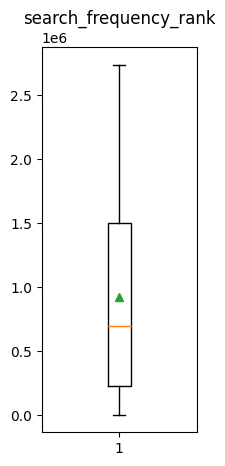

In [ ]:
plt.figure(figsize=(2,5))
plt.boxplot(df['search_frequency_rank'],showmeans=True)
plt.title('search_frequency_rank')
plt.show()

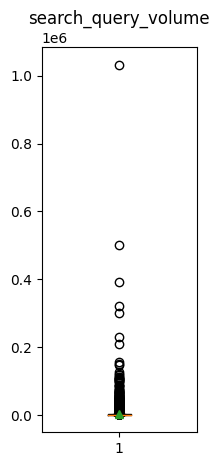

In [ ]:
plt.figure(figsize=(2,5))
plt.boxplot(df['search_query_volume'],showmeans=True)
plt.title('search_query_volume')
plt.show()

## Data Cleaning

In [ ]:
# data filtering
# use concatenated dataframe to increase the sample size for this segment
df1 = concated[concated.search_frequency_rank <= 8000]
df2 = df[(df.search_frequency_rank > 1000) & (df.search_frequency_rank <= 32000)]
df3 = df[(df.search_frequency_rank > 30000) & (df.search_frequency_rank <= 110000)]
df4 = df[df.search_frequency_rank > 100000]

In [ ]:
def remove_outliers(df, column_name):
    """
    Remove outliers from a dataframe based on the IQR method for a specified column.
    """
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return filtered_df

df1_filtered = remove_outliers(df1, 'search_query_volume')
df2_filtered = remove_outliers(df2, 'search_query_volume')
df3_filtered = remove_outliers(df3, 'search_query_volume')
df4_filtered = remove_outliers(df4, 'search_query_volume')


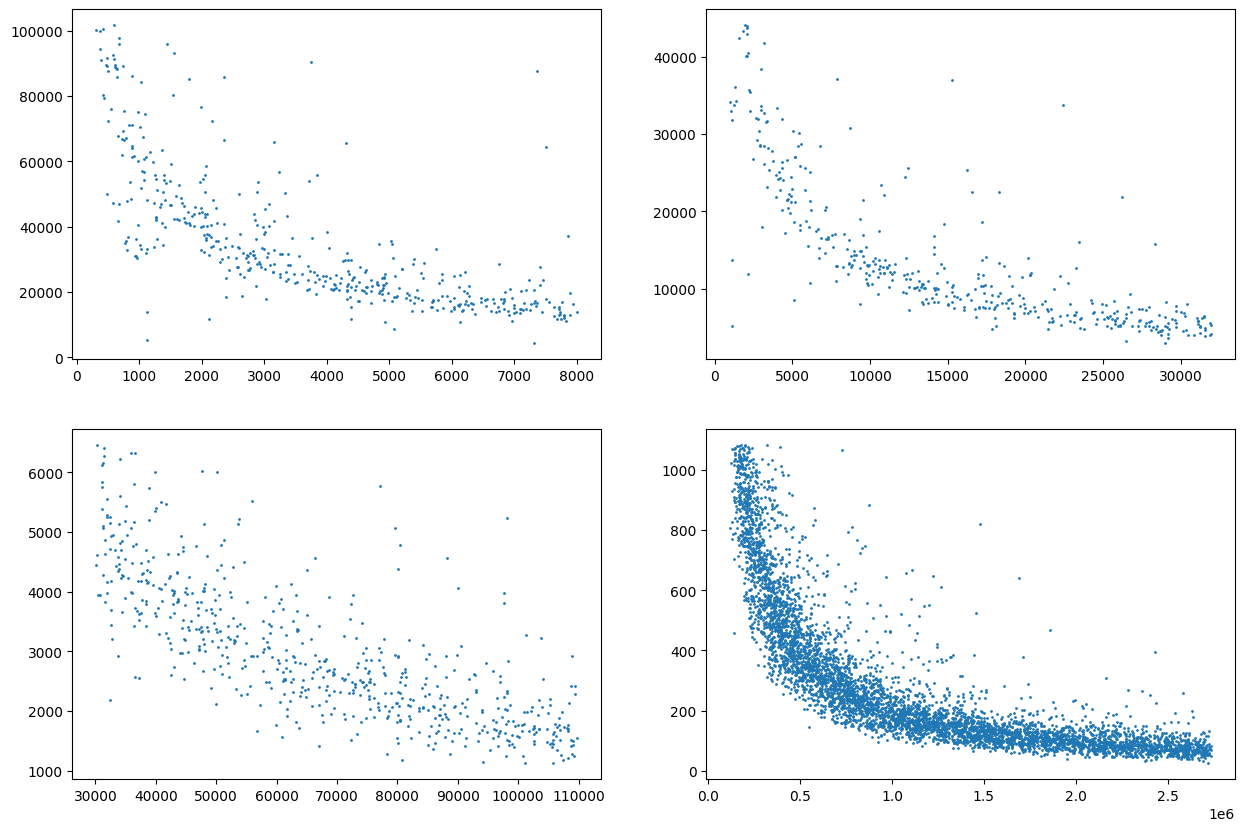

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
# axs[0, 0].scatter(df1['search_frequency_rank'],df1['search_query_volume'], s=1)
# axs[0, 1].scatter(df2['search_frequency_rank'],df2['search_query_volume'], s=1)
# axs[1, 0].scatter(df3['search_frequency_rank'],df3['search_query_volume'], s=1)
# axs[1, 1].scatter(df4['search_frequency_rank'],df4['search_query_volume'], s=1)

axs[0, 0].scatter(df1_filtered['search_frequency_rank'],df1_filtered['search_query_volume'], s=1)
axs[0, 1].scatter(df2_filtered['search_frequency_rank'],df2_filtered['search_query_volume'], s=1)
axs[1, 0].scatter(df3_filtered['search_frequency_rank'],df3_filtered['search_query_volume'], s=1)
axs[1, 1].scatter(df4_filtered['search_frequency_rank'],df4_filtered['search_query_volume'], s=1)

## First Polynomial Model


In [ ]:
# Split the data to train and test set, 75% of data as training set and 25% of data as testing set
# X as feature
# Y as target variable
X = np.array(df1_filtered['search_frequency_rank']).reshape(-1,1)
y = np.array(df1_filtered['search_query_volume'])
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, random_state=0, train_size = .75)

In [ ]:
regressor = make_pipeline(PolynomialFeatures(4), LinearRegression())
regressor.fit(X1_train, y1_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=4)),
                ('linearregression', LinearRegression())])

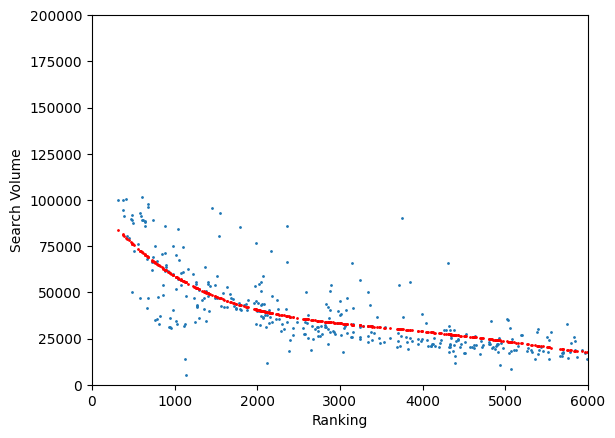

In [ ]:
# Plot the Linear Regression for this model
plt.scatter(df1_filtered['search_frequency_rank'],df1_filtered['search_query_volume'], s=1)
plt.scatter(X, regressor.predict(X), color = 'red', s=1)
plt.ylim(0,200000)
plt.xlim(0, 6000)
plt.xlabel('Ranking')
plt.ylabel('Search Volume')
plt.show()

In [ ]:
poly_score = regressor.score(X1_test,y1_test)
score_df = pd.DataFrame({'Model Name':['Polynomial Model 1'], 'Score':[poly_score]})
score_df

,Model Name,Score
0,Polynomial Model 1,0.632383


##Polynomial Model 2



### First fit using the filtered dataset

In [ ]:
# Split the data to train and test set, 75% of data as training set and 25% of data as testing set
# X as feature
# Y as target variable
X = np.array(df2_filtered['search_frequency_rank']).reshape(-1,1)
y = np.array(df2_filtered['search_query_volume'])
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, random_state=0, train_size = .75)

In [ ]:
regressor1 = make_pipeline(PolynomialFeatures(4), LinearRegression())
regressor1.fit(X2_train, y2_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=4)),
                ('linearregression', LinearRegression())])

**Plot the Polynomial regression model for predicting**

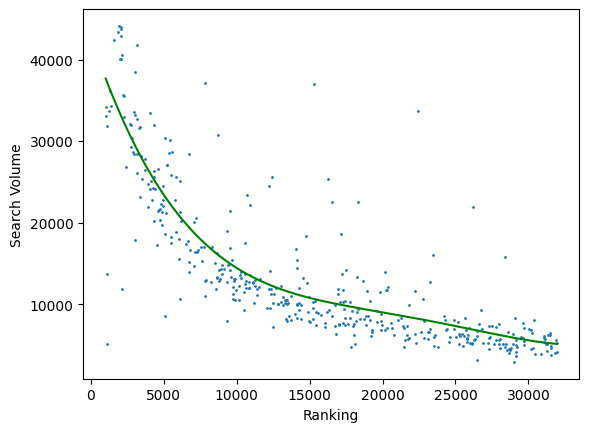

In [ ]:
plt.scatter(X,y, s=1)
plt.plot(X, regressor1.predict(X), color = 'green')
plt.xlabel('Ranking')
plt.ylabel('Search Volume')
plt.show()

This model may generate negative ouputs, use loss function to deal with this issue

In [ ]:
poly1_score = regressor1.score(X2_test, y2_test)
poly1_score

0.7307144394598715

### Second round of cleaning and fitting

Further cleaning the dataset by using the polynomial model as bemchmark for limiting residulas

In [ ]:
# Predicting search query volume for each point in the cleaned dataset using the polynomial model
X_cleaned = np.array(df2_filtered['search_frequency_rank']).reshape(-1,1)
y_cleaned = regressor1.predict(X_cleaned)

# Calculating residuals (differences between observed and predicted values)
residuals = df2_filtered['search_query_volume'].values - y_cleaned

# Identifying outliers based on residuals
# Using a similar IQR method for residuals
residuals_Q1 = np.percentile(residuals, 25)
residuals_Q3 = np.percentile(residuals, 75)
residuals_IQR = residuals_Q3 - residuals_Q1

residuals_lower_bound = residuals_Q1 - 1.5 * residuals_IQR
residuals_upper_bound = residuals_Q3 + 1.5 * residuals_IQR

# Filtering out these outliers
further_cleaned_data = df2_filtered[(residuals >= residuals_lower_bound) & (residuals <= residuals_upper_bound)]



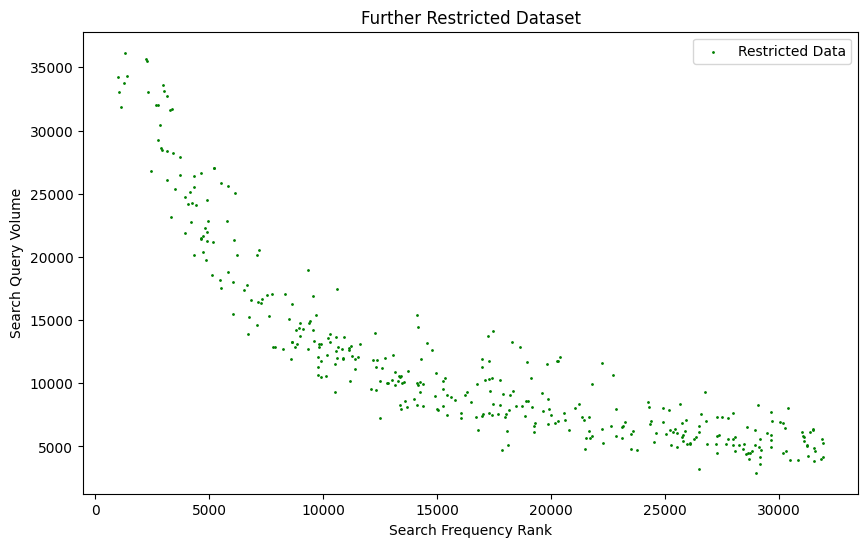

In [ ]:
# Checking the size of the data after this further cleaning
plt.figure(figsize=(10, 6))
plt.scatter(further_cleaned_data['search_frequency_rank'], further_cleaned_data['search_query_volume'], color='green', label='Restricted Data', s=1)
plt.xlabel('Search Frequency Rank')
plt.ylabel('Search Query Volume')
plt.title('Further Restricted Dataset')
plt.legend()
plt.show()

In [ ]:
X = np.array(further_cleaned_data['search_frequency_rank']).reshape(-1,1)
y = np.array(further_cleaned_data['search_query_volume'])
X5_train, X5_test, y5_train, y5_test = train_test_split(X, y, random_state=0, train_size = .75)

In [ ]:
regressor1 = make_pipeline(PolynomialFeatures(3), LinearRegression())
regressor1.fit(X5_train, y5_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

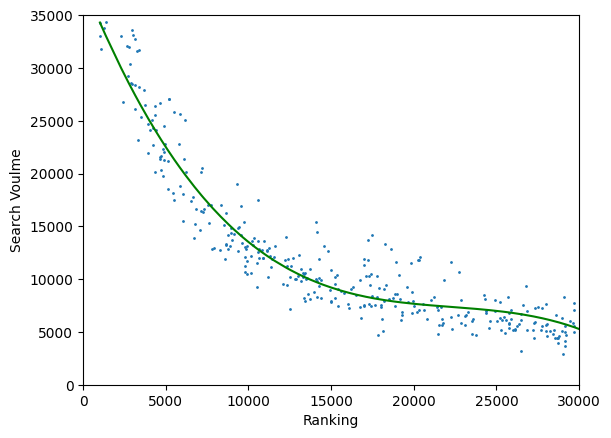

In [ ]:
#plot the graph and we can have an idea of how well it fits.
plt.scatter(X, y, s=1)
plt.plot(X, regressor1.predict(X), color = 'green')
plt.xlabel('Ranking')
plt.ylabel('Search Voulme')
plt.ylim(0, 35000)
plt.xlim(0, 30000)
# Show the plot
plt.show()

In [ ]:
poly1_score = regressor1.score(X2_test, y2_test)
score_df.loc[len(score_df)] = ['Polynomial Model 2', poly1_score]
score_df

,Model Name,Score
0,Polynomial Model 1,0.632383
1,Polynomial Model 2,0.734593


## Polynomial Model 3

In [ ]:
# Split the data to train and test set, 75% of data as training set and 25% of data as testing set
# X as feature
# Y as target variable
X = np.array(df3_filtered['search_frequency_rank']).reshape(-1,1)
y = np.array(df3_filtered['search_query_volume'])
X3_train, X3_test, y3_train, y3_test = train_test_split(X, y, random_state=0, train_size = .75)

In [ ]:
regressor2 = make_pipeline(PolynomialFeatures(3), LinearRegression())
regressor2.fit(X3_train, y3_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

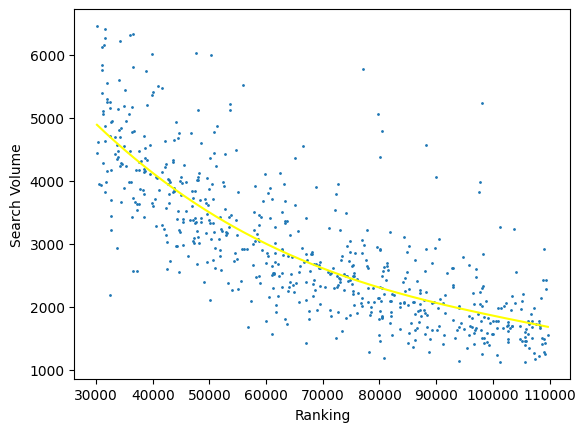

In [ ]:
plt.scatter(X,y, s=1)
plt.plot(X, regressor2.predict(X), color = 'yellow')
plt.xlabel('Ranking')
plt.ylabel('Search Volume')
plt.show()

In [ ]:
poly2_score = regressor2.score(X3_test, y3_test)
score_df.loc[len(score_df)] = ['Polynomial Model 3', poly2_score]
score_df

,Model Name,Score
0,Polynomial Model 1,0.632383
1,Polynomial Model 2,0.734593
2,Polynomial Model 3,0.562759


## Polynomial Model 4

In [ ]:
# Split the data to train and test set, 75% of data as training set and 25% of data as testing set
# X as feature
# Y as target variable
X = np.array(df4_filtered['search_frequency_rank']).reshape(-1,1)
y = np.array(df4_filtered['search_query_volume'])
X4_train, X4_test, y4_train, y4_test = train_test_split(X, y, random_state=0, train_size = .75)

In [ ]:
regressor3 = make_pipeline(PolynomialFeatures(3), LinearRegression())
regressor3.fit(X4_train, y4_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

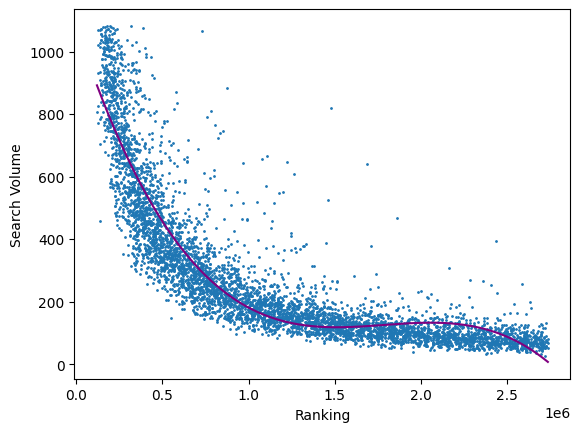

In [ ]:
plt.scatter(X,y, s=1)
plt.plot(X, regressor3.predict(X), color = 'purple')
plt.xlabel('Ranking')
plt.ylabel('Search Volume')
plt.show()

In [ ]:
poly3_score = regressor3.score(X4_test, y4_test)
score_df.loc[len(score_df)] = ['Polynomial Model 4', poly3_score]
score_df

,Model Name,Score
0,Polynomial Model 1,0.632383
1,Polynomial Model 2,0.734593
2,Polynomial Model 3,0.562759
3,Polynomial Model 4,0.854657


## Final plot

In [ ]:
n_array = np.arange(1000001)
n = n_array.reshape(len(n_array), 1)

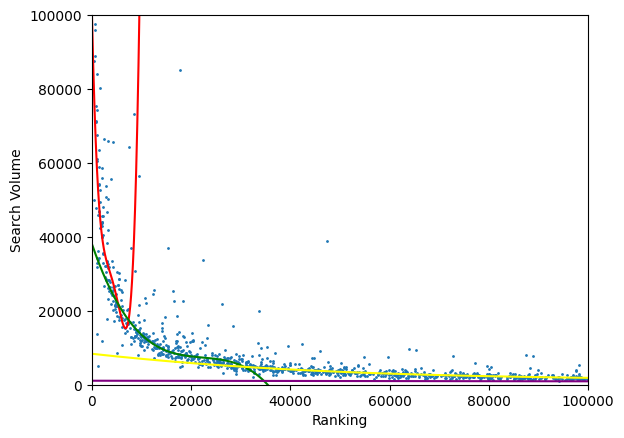

In [ ]:
plt.scatter(df['search_frequency_rank'],df['search_query_volume'], s=1)
plt.plot(n, regressor.predict(n), color = 'red')
plt.plot(n, regressor1.predict(n), color = 'green')
plt.plot(n, regressor2.predict(n), color = 'yellow')
plt.plot(n, regressor3.predict(n), color = 'purple')
plt.ylim(0, 100000)
plt.xlim(0, 100000)
plt.xlabel('Ranking')
plt.ylabel('Search Volume')
plt.show()

## Determine the intersections

In [ ]:
def approximate_intersection(start_int, end_int, model1, model2):

  n_array = np.arange(start_int, end_int)
  n = n_array.reshape(len(n_array), 1)
  y_pred1 = model1.predict(n)
  y_pred2 = model2.predict(n)
  df = pd.DataFrame({'x':n_array,'model1':y_pred1, 'model2':y_pred2, 'diff':abs(y_pred1-y_pred2)})
  df = df[df['diff'] == df['diff'].min()]
  return df

inter1 = approximate_intersection(4000,6000, regressor, regressor1)
inter2 = approximate_intersection(30000,32000, regressor1, regressor2)
inter3 = approximate_intersection(144000,146000, regressor2, regressor3)

intersection = inter1.append(inter2).append(inter3)
intersection = intersection.reset_index(drop=True)
intersection

<ipython-input-36-2d97076de4a0>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  intersection = inter1.append(inter2).append(inter3)
<ipython-input-36-2d97076de4a0>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  intersection = inter1.append(inter2).append(inter3)


,x,model1,model2,diff
0,5273,21862.049529,21861.897848,0.151682
1,30708,4843.713140,4843.854619,0.141479
2,145012,857.514877,857.506538,0.008339


## Unify the 4 Models

In [ ]:
class CombinedModel:
  def __init__(self, poly, poly1, poly2, poly3, intersections):
    self.poly = regressor
    self.poly1 = regressor1
    self.poly2 = regressor2
    self.poly3 = regressor3
    self.intersections = intersections

  def split(self, x):
    intersections = sorted(self.intersections)
    x = x[np.argsort(x[:, 0])]
    split_arrays = []
    start_idx = 0
    # Iterate through the intersection points
    for point in intersections:
        end_idx = np.searchsorted(x[:, 0], point, side='right')
        split_arrays.append(x[start_idx:end_idx])
        start_idx = end_idx

    split_arrays.append(x[start_idx:])
    return split_arrays

  def predict(self, x):
    arr_list = self.split(x)
    y = np.array([])
    if any(arr_list[0]):
      y1 = self.poly.predict(arr_list[0])
      y = np.concatenate((y, y1), axis=0)
    if any(arr_list[1]):
      y2 = self.poly1.predict(arr_list[1])
      y = np.concatenate((y, y2), axis=0)
    if any(arr_list[2]):
      y3 = self.poly2.predict(arr_list[2])
      y = np.concatenate((y, y3), axis=0)
    if any(arr_list[3]):
      y4 = self.poly3.predict(arr_list[3])
      y = np.concatenate((y, y4), axis=0)
    return y

  def score(self, x, y_true):
    # Make predictions
    y_pred = self.predict(x)
    # Calculate the total sum of squares
    ss_tot = sum((y_true - y_true.mean()) ** 2)
    # Calculate the residual sum of squares
    ss_res = sum((y_true - y_pred) ** 2)
    # Calculate R-squared
    r_squared = 1 - (ss_res / ss_tot)

    return r_squared


In [ ]:
n2_array = np.arange(100000)
n2 = n2_array.reshape(len(n2_array), 1)

ml_model = CombinedModel(regressor, regressor1, regressor2, regressor3, intersection['x'].to_list())
y_res = ml_model.predict(n2)
y_res




array([100520.60035043, 100462.24642026, 100403.93182498, ...,
         1858.64825164,   1858.62932797,   1858.61040448])

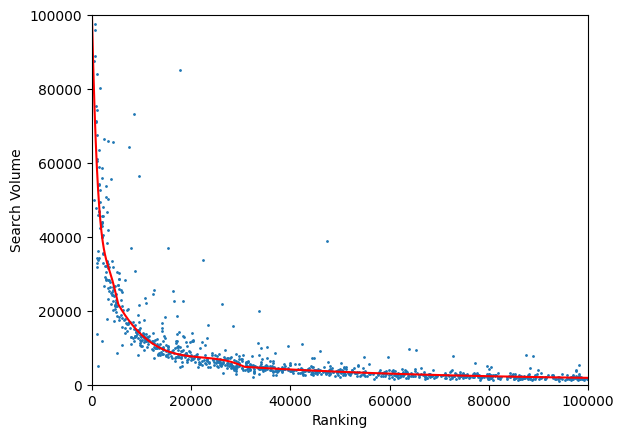

In [ ]:
plt.scatter(df['search_frequency_rank'],df['search_query_volume'], s=1)
plt.plot(n2, y_res, color = 'red')
plt.ylim(0,100000)
plt.xlim(0,100000)
plt.xlabel('Ranking')
plt.ylabel('Search Volume')
plt.show()

## Benchmarking

In [ ]:
# We use previously cleaned datasets df1 to df4 filtered with outliers removed. Note that the dataframe needs to be sorted and free from duplicates
df_filtered = pd.concat([df1_filtered, df2_filtered, df3_filtered, df4_filtered]).sort_values('search_frequency_rank').drop_duplicates()

X_final = np.array(df_filtered['search_frequency_rank']).reshape(-1,1)
y_final = np.array(df_filtered['search_query_volume'])

y_final_pred = ml_model.predict(X_final)


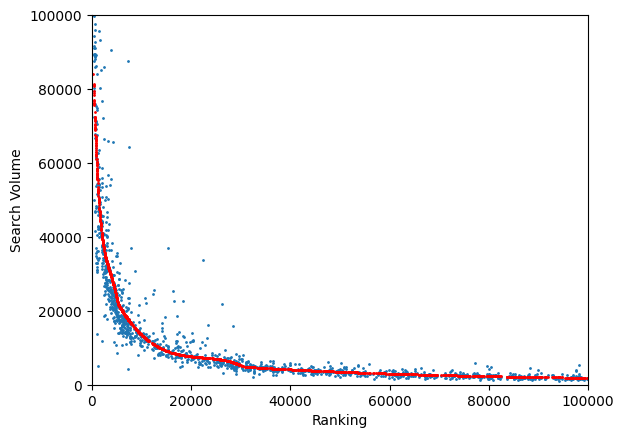

In [ ]:
# Now we graph the result on x in [0, 100000], y in [0, 100000]
plt.scatter(X_final,y_final, s=1)
plt.scatter(X_final, ml_model.predict(X_final), color = 'red', s=1)
plt.ylim(0,100000)
plt.xlim(0,100000)
plt.xlabel('Ranking')
plt.ylabel('Search Volume')
plt.show()

In [ ]:
#Let's test out the overall score on a cleaned dataset:
ml_model.score(X_final, y_final)



0.8977346029116527